# Домашнее задание №4

Задание присылать на почту **aleksartmonov@gmail.com** в форматах *.ipynb* и отрендеренный результат в *.html*

В теме письма указать **AU2018 HW4 <Фамилия Имя>**

soft deadline: 8.04.2018T23:59:00+0300

hard deadline: 15.04.2018T23:59:00+0300


### Поиск изображений по содержанию (30 баллов)

Вам предстоит построить систему, которая позволит выполнить поиск изображений по содержанию в базе Corel-10k, которая приложена к домашнему заданию. База состоит из 100 классов изображений по 100 изображений в каждом классе. Имя каждого изображения в базе состоит из **X.JPEG**, где X - число от 1 до 10000. Изображения из одного класса лежат подряд в промежутке 1-100, 101-200, и тд. В файле **test.dat** лежит список картинок, которые не должны участвовать в построении поисковой базы, но по которым надо будет сделать 1000 поисковых запросов. Ограничение по памяти -- 2Гб.

1. По изображениям не попавшим в **test.dat** посчитайте дескриптор с помощью алгоритма GIST.
   
2. Разбейте дескрипторы всех изображений на 100 кластеров с помощью K-Means.

3. Для каждого кластера постройте функцию хэширования (LSH), с помощью которой закодируйте каждое изображение в тренировочной выборке.

4. Релизуйте функцию `retrieve` и сделайте 1000 запросов изображениями из файла **test.dat**.

5. Продемонстрируйте работу `retrieve` на 5-ти случайных изображениях из **test.dat**. Замерьте время исполнения поискового запроса. Сделайте возможность вызвать `retrieve` без построения индекса, то есть приложите в решение индексированную базу, если только время построения индекса не укладывается в 1 минуту.  
    
6. Для каждого запроса нужно оценить APk, где k=10 и посчитать среднее значение этой величины по всем запросам (MAPk).

Так же за это задание можно получить еще до 20-ти дополнительных баллов. Качество поиска вы посчитаете сами, а вот со скоростью есть некоторые трудности, реализуйте ваше решение таким образом, чтобы я мог из командной строки вызвать:

`python cbir.py --retrieve /path/to/image`

1. Вы можете сделать быстрый поиск. Если качество вашего поиска окажется выше, чем медиана качества по всем поисковым движкам, то вы принимаете участие в борьбе за 10 призовых баллов. Первое место получает 10 баллов и шоколадку, второе 9, третье 8 и т.д. 

2. Вы можете сделать хороший поиск. Если ваш поиск окажется быстрее, чем медиана среднего времени работы других участников, то вы принимаете участие в борьбе за точный поиск. Распределение баллов здесь будет такое же как и в конкурсе на скорость. 

Для достижения лучших результатов вам придется регулировать несколько параметров алгоритма:
- Дескриптор. Можете взять что угодно вместо GIST
- Количество кластеров k-means
- Длину кода LSH
- etc 

Принципиально нельзя использовать готовые поисковые движки. И помните о том, что время поиска очень важный параметр.

Удачи!


In [1]:
import cv2
import gist
import pickle
import gzip as gz
import numpy as np
import matplotlib.pylab as plt

from tqdm import tqdm
from pathlib import Path
from lshash.lshash import LSHash
from sklearn.cluster import KMeans
from sklearn.neighbors import LSHForest

%matplotlib inline

# Tools

In [2]:
def pickle_dump(obj: object, path: str):
    with gz.open(path, 'w') as f:
        pickle.dump(obj, f)
        

def pickle_load(path: str) -> object:
    with gz.open(path, 'r') as f:
        return pickle.load(f)

# Plotting

In [3]:
def read_img(path: str) -> np.array:
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)


def show_img(path: str):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
    ax.set_axis_off()
    ax.imshow(read_img(path));
               

def show_images(paths: [str]):
    nrows = (len(paths) + 1) // 2
    fix, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(10, 4 * nrows))

    for i, path in enumerate(paths):
        ax = axs[i // 2][i % 2]
        ax.set_axis_off()
        ax.imshow(read_img(path))

# Search Engine

In [4]:
class ImageSearchEngine:
    def __init__(self, n_clusters=10, hash_size=10):
        self.n_clusters = n_clusters
        self.hash_size = hash_size
        self._distances = np.zeros((n_clusters, n_clusters))
        self._order = np.zeros((n_clusters, n_clusters))
        self._kmeans = KMeans(n_clusters=n_clusters, n_jobs=4)
        self._lsh = {cluster: LSHash(self.hash_size, 960) for cluster in range(self.n_clusters)}
    
    def build(self, images: [str], *, features=None):
        if features is None:
            features = self.extract_features(images)
        
        clusters = self._kmeans.fit_predict(features)
        self._calculate_distances()
        self._order = self._distances.argsort(axis=1)
        
        for img, cluster, feature in tqdm(zip(images, clusters, features), desc='lsh'):
            self._lsh[cluster].index(feature, extra_data=img)      
    
    def _calculate_distances(self):
        centers = self._kmeans.cluster_centers_
        
        for i in range(self.n_clusters):
            for j in range(i, self.n_clusters):
                dist = np.linalg.norm(centers[i] - centers[j])
                self._distances[i][j] = dist
                self._distances[j][i] = dist
    
    def _retrieve(self, cluster: int, feature: np.array, top_n: int) -> [str]:
        retrived = []
        
        for cluster_ in self._order[cluster]:
            result = self._lsh[cluster_].query(feature, num_results=top_n)
            retrived += list(map(self._get_path, result))
                
            if len(retrived) >= top_n:
                break
        
        return retrived[:top_n]
                
    
    def retrieve(self, images: [str], *, top_n=10, features=None) -> [str]:
        if not isinstance(images, list):
            images = [images]
        
        if features is None:
            features = self.extract_features(images)
            
        clusters = self._kmeans.predict(features)
        
        results = []
        
        for cluster, feature in tqdm(zip(clusters, features), desc='lsh'):
            results.append(self._retrieve(cluster, feature, top_n))
            
        return results
    
    @staticmethod
    def _get_path(index: ((np.array, str), float)) -> str:
        return index[0][1]
    
    @classmethod
    def _extract(cls, img: np.array) -> np.array:
        return gist.extract(img)
    
    @classmethod
    def extract_features(cls, images: [str]) -> np.array:
        return np.array([cls._extract(read_img(img)) for img in tqdm(images, desc='extracting')])

# Evaluation

In [5]:
def get_img_index(path: str) -> int:
    return int(path.rsplit('/', 1)[-1].split('.', 1)[0])


def get_img_label(path: str) -> int:
    return (get_img_index(path) - 1) // 100


def average_precision(image: str, result: [str]) -> float:
    label = get_img_label(image)
    labels = np.array([get_img_label(img) for img in result])
    return np.mean((labels == label).cumsum() / (np.arange(len(labels)) + 1))
    

def mean_average_precision(images: [str], results: [[str]]) -> float:
    return np.mean([average_precision(image, result) for image, result in zip(images, results)])

# Data

In [6]:
FEATURES = 'features.pkl.gz'

In [7]:
invalid = ['Corel/7264.jpg']
train = list(map(str, Path('Corel').glob('*.jpg')))
test = list(filter(lambda it: it, Path('test.dat').read_text().split('\n')))

# remove test images from the train
train = sorted(list(set(train) - set(test)))
test = sorted(list(set(test) - set(invalid)))

In [8]:
if Path(FEATURES).exists():
    features = pickle_load(FEATURES)
else:
    features = ImageSearchEngine.extract_features(train)
    pickle_dump(features, FEATURES)

In [9]:
features_test = ImageSearchEngine.extract_features(test)

extracting: 100%|██████████| 999/999 [01:08<00:00, 14.52it/s]


In [10]:
cbir = ImageSearchEngine(hash_size=6)
cbir.build(train, features=features)

lsh: 8997it [00:00, 11311.50it/s]


In [11]:
results = cbir.retrieve(train, features=features, top_n=10)
print(f'Train MAP: {mean_average_precision(train, results):0.3f}')

lsh: 8997it [03:10, 47.11it/s]


Train MAP: 0.480


In [12]:
results = cbir.retrieve(test, features=features_test, top_n=10)
print(f'Test MAP: {mean_average_precision(test, results):0.3f}')

lsh: 999it [00:22, 43.96it/s]


Test MAP: 0.256


In [13]:
# measure time
cbir.retrieve(test[:100], top_n=10);

extracting: 100%|██████████| 100/100 [00:08<00:00, 11.64it/s]
lsh: 100it [00:02, 47.00it/s]


# Examples

## Example 1

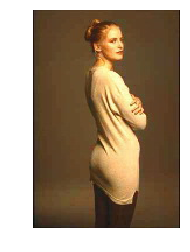

In [14]:
show_img(test[3])

extracting: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]
lsh: 1it [00:00, 237.92it/s]


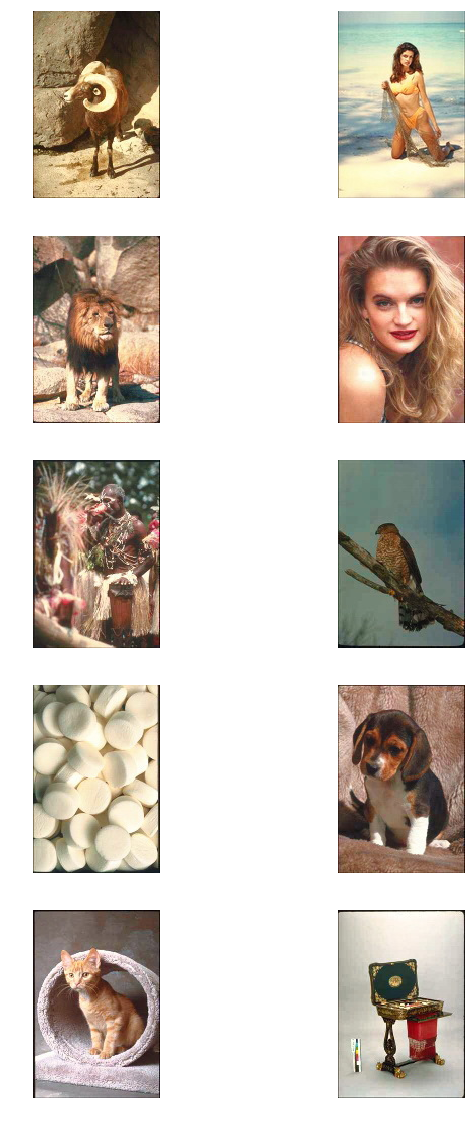

In [15]:
result = cbir.retrieve(test[3], top_n=10)[0]
show_images(result)

## Example 2

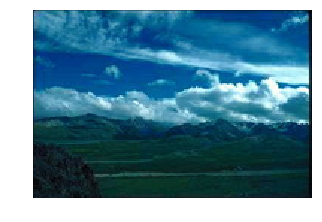

In [16]:
show_img(test[30])

extracting: 100%|██████████| 1/1 [00:00<00:00, 13.79it/s]
lsh: 1it [00:00, 34.56it/s]


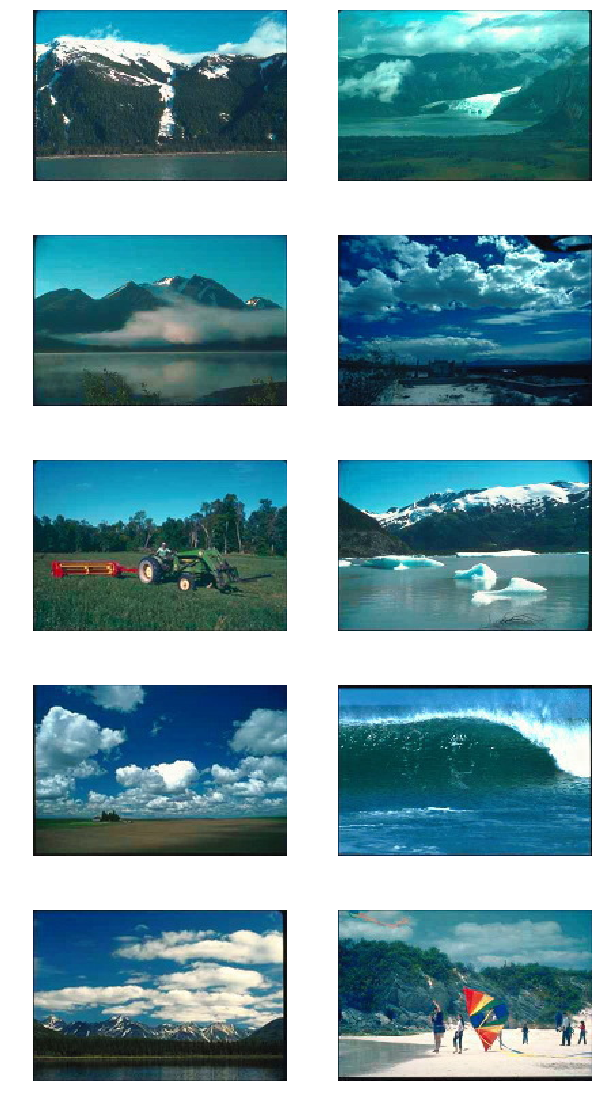

In [17]:
result = cbir.retrieve(test[30], top_n=10)[0]
show_images(result)

## Example 3

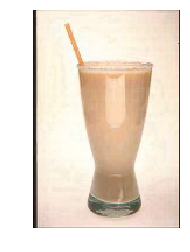

In [18]:
show_img(test[86])

extracting: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]
lsh: 1it [00:00, 177.00it/s]


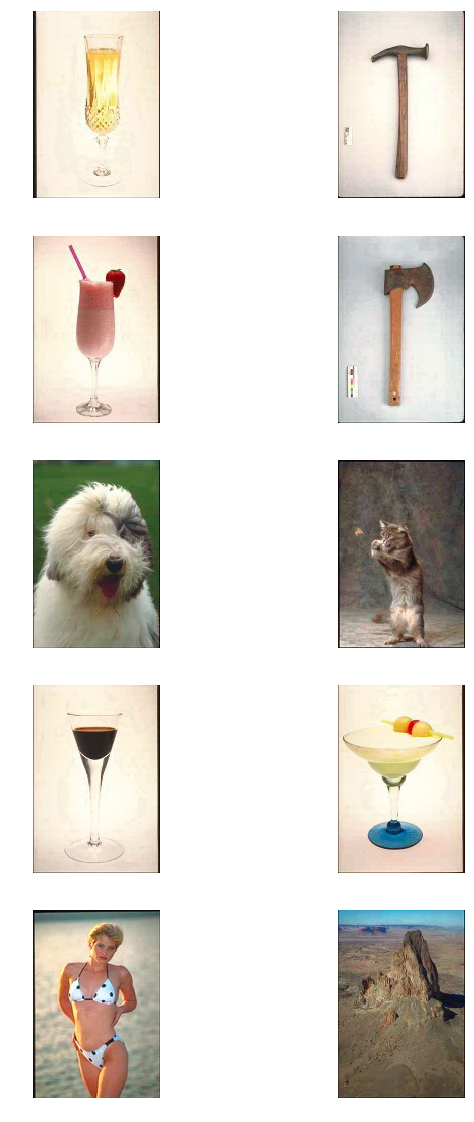

In [19]:
result = cbir.retrieve(test[86], top_n=10)[0]
show_images(result)

## Example 4

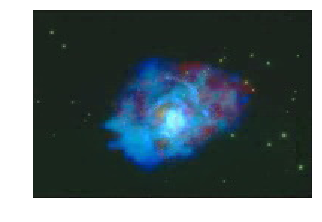

In [20]:
show_img(test[110])

extracting: 100%|██████████| 1/1 [00:00<00:00, 13.82it/s]
lsh: 1it [00:00, 79.21it/s]


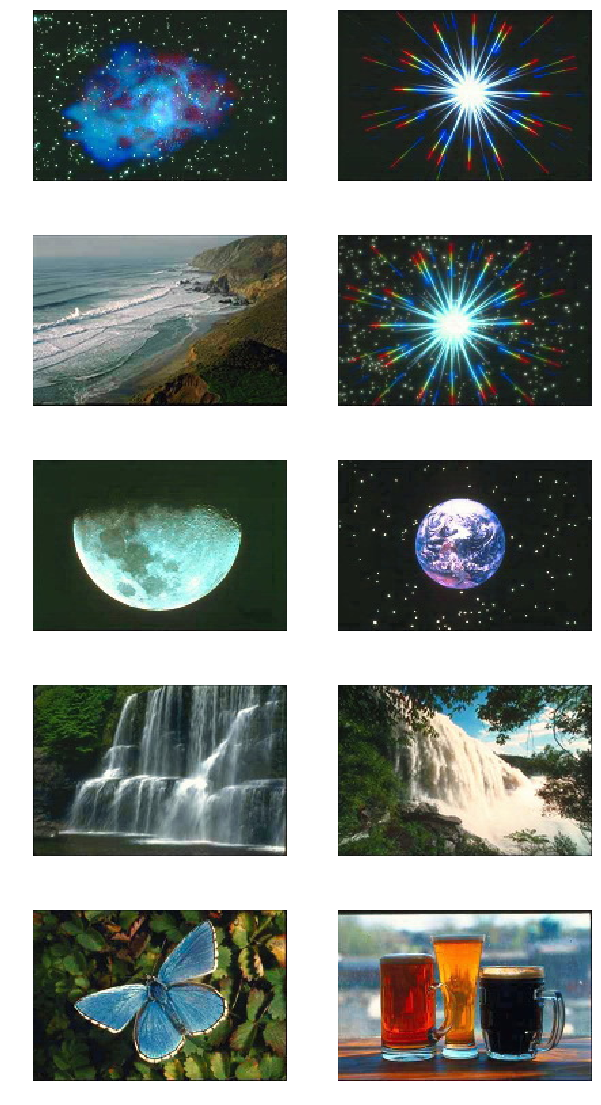

In [21]:
result = cbir.retrieve(test[110], top_n=10)[0]
show_images(result)

## Example 5

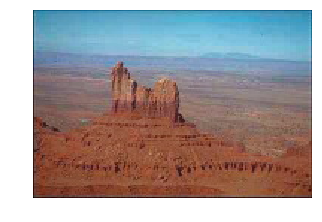

In [22]:
show_img(test[620])

extracting: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]
lsh: 1it [00:00, 68.54it/s]


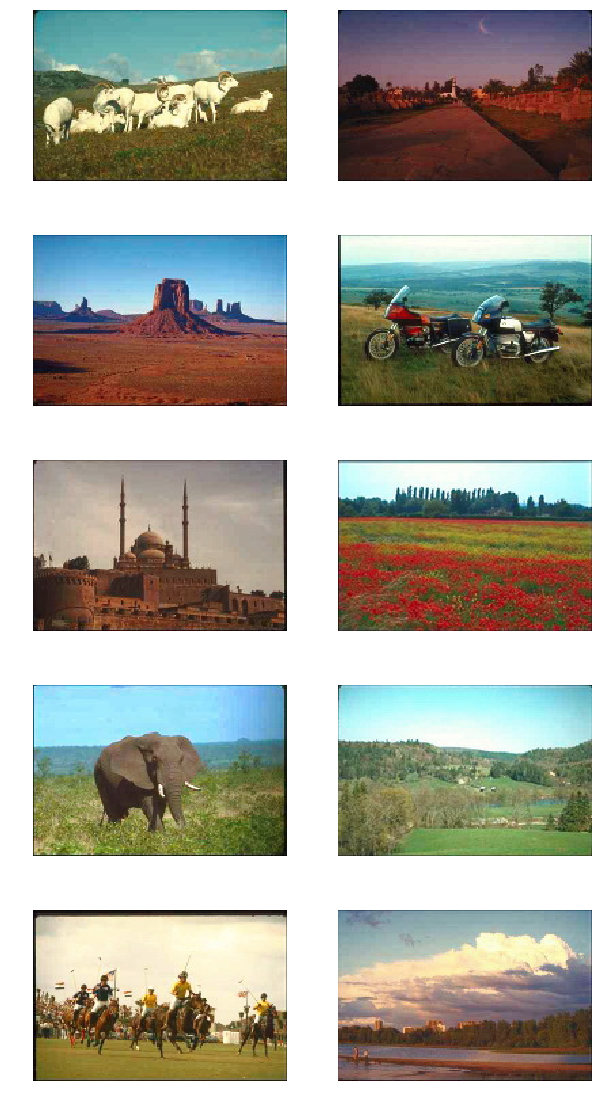

In [23]:
result = cbir.retrieve(test[620], top_n=10)[0]
show_images(result)